In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn

import matplotlib.pyplot as plt
% matplotlib inline

from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance

from sklearn import cross_validation
import seaborn as sns

# Any results you write to the current directory are saved as output.

In [2]:
train_data = pd.read_csv('train.csv')
pd.options.display.max_rows = 999
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Number of outcome classes
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

From the number of classess and their proportion, we can see that it is a binary classification problem with imbalanced category. Therefore, we need to consider using f1-score as the evalution metric

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
test_data = pd.read_csv('test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
# Combine training and testing data together
data = pd.concat([train_data, test_data]).reset_index(drop=True)

In [8]:
# Make a copy oof original data for testing the preprocessing algorithm
data_rd1 = data.copy()

Given that test data has lots of NaN values in cabin. We will drop this feature.

In [9]:
# data_rd1.drop(labels='Cabin', axis=1, inplace=True)
data_rd1.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [10]:
# Create function for extracting information from Name
import re
import string
def name_parsing(text):
    # Remove bracket content
    title = []
    middle_name = []
    last_name = []
    
    title_bank = ['Miss', 'Mr', 'Mrs', 'Dr', 'Master', 'Major', 'Rev', 'Capt', 'Lady',
       'Mme', 'Ms', 'Col', 'Mlle']
    
    for i in range(len(text)):
        # Remove the content in bracket
        text.iloc[i] = re.sub("[\(\[].*?[\)\]]", "", text.iloc[i])
        # Remove punctuation
        translation = text.iloc[i].maketrans("","", string.punctuation)
        # Split
        # ext_trans = text[i].translate(translation)
        text_split = text.iloc[i].split()
        lastname_flag = 0
        title_flag = 0
        for j in range(len(text_split)):
            if (',' in text_split[j]) & (lastname_flag == 0):
                last_name.append(text_split[j].translate(translation))
                last_name_flag = 1
            
            if ('.' in text_split[j]) & (title_flag == 0):
                title.append(text_split[j].translate(translation))                
                title_flag = 1                
    
        if last_name_flag == 0:
            last_name.append(np.nan)
        
        if title_flag == 0:
            title.append(np.nan)
            
        # first_name.append(text_split[-2].translate(translation))
        middle_name.append(text_split[-1].translate(translation))
        
    return pd.Series(title), pd.Series(last_name), pd.Series(middle_name)

In [11]:
title, last, middle = name_parsing(data_rd1['Name'])

In [12]:
name_type = title.unique()
name_map = {}

for i in range(len(name_type)):
    name_map[name_type[i]] = i

title_name_num = title.map(name_map)
data_rd1['title_name'] = list(title)

In [13]:
data_rd1.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,title_name
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath",0,4,1,female,1,1.0,113803,Mrs
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [14]:
# To many categorical values for titles, try combining them and apply one hot
data_rd1['title_name'].value_counts()/np.sum(data_rd1['title_name'].value_counts())*100

Mr          57.830405
Miss        19.862490
Mrs         15.049656
Master       4.660046
Dr           0.611154
Rev          0.611154
Col          0.305577
Major        0.152788
Ms           0.152788
Mlle         0.152788
Countess     0.076394
Capt         0.076394
Sir          0.076394
Lady         0.076394
Dona         0.076394
Mme          0.076394
Jonkheer     0.076394
Don          0.076394
Name: title_name, dtype: float64

In [15]:
# Map title name to represent better the gender and ages
title_map = {"Capt":       "Officer",
            "Col":        "Officer",
            "Major":      "Officer",
            "Jonkheer":   "Royalty",
            "Don":        "Royalty",
            "Sir" :       "Royalty",
            "Dr":         "Officer",
            "Rev":        "Officer",
            "the Countess":"Royalty",
            "Dona":       "Royalty",
            "Mme":        "Mrs",
            "Mlle":       "Miss",
            "Ms":         "Mrs",
            "Mr" :        "Mr",
            "Mrs" :       "Mrs",
            "Miss" :      "Miss",
            "Master" :    "Master",
            "Lady" :      "Royalty"}

In [16]:
data_rd1['title_name'] = data_rd1['title_name'].map(title_map)
data_rd1['title_name'].value_counts()/np.sum(data_rd1['title_name'].value_counts())*100

Mr         57.874618
Miss       20.030581
Mrs        15.290520
Master      4.663609
Officer     1.758410
Royalty     0.382263
Name: title_name, dtype: float64

In [17]:
one_hot_title = pd.get_dummies(data_rd1['title_name'])
data_rd1 = data_rd1.join(one_hot_title)
# data_rd1.drop(labels='title_name', axis=1, inplace=True)
data_rd1.drop(labels='Name', axis=1, inplace=True)

In [18]:
data_rd1.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,title_name,Master,Miss,Mr,Mrs,Officer,Royalty
0,22.0,S,7.2500,0,1,3,male,1,0.0,A/5 21171,Mr,0,0,1,0,0,0
1,38.0,C,71.2833,0,2,1,female,1,1.0,PC 17599,Mrs,0,0,0,1,0,0
2,26.0,S,7.9250,0,3,3,female,0,1.0,STON/O2. 3101282,Miss,0,1,0,0,0,0
3,35.0,S,53.1000,0,4,1,female,1,1.0,113803,Mrs,0,0,0,1,0,0
4,35.0,S,8.0500,0,5,3,male,0,0.0,373450,Mr,0,0,1,0,0,0


In [19]:
# Extract string and number information from ticket
ticket_ori = data_rd1['Ticket']

ticket_num1 = []
ticket_num2 = []
ticket_str = []
for tk in range(len(ticket_ori)):
    if len(re.findall(r'\d+', ticket_ori.iloc[tk])) ==0:
        ticket_num1.append(np.nan)
        ticket_num2.append(np.nan)
    else:
        ticket_num_temp = re.findall(r'\d+', ticket_ori.iloc[tk])
        if len(ticket_num_temp)>1:
            ticket_num1.append(np.int(ticket_num_temp[0]))
            ticket_num2.append(np.int(ticket_num_temp[-1]))
        else:
            ticket_num1.append(0)
            ticket_num2.append(np.int(ticket_num_temp[-1]))
        
    if len(re.findall("[a-zA-Z]+", ticket_ori.iloc[tk]))==0:
        ticket_str.append(np.nan)
    else:
        ticket_str.append(re.findall("[a-zA-Z]+", ticket_ori.iloc[tk]))
        

In [20]:
# data_rd1=data_rd1.join(pd.Series(ticket_str, name='ticket_str'), how='outer')
# data_rd1.drop(labels='ticket_str', axis=1, inplace=True)

In [21]:
data_rd1=data_rd1.join(pd.Series(ticket_num1, name='ticket_num1'), how='outer')
data_rd1=data_rd1.join(pd.Series(ticket_num2, name='ticket_num2'), how='outer')
data_rd1.drop(labels='Ticket', axis=1, inplace=True)

In [22]:
# Use mapping function to convert Sex into binary digits
data_rd1['Sex'] = data_rd1['Sex'].map({'female':1, 'male':0})

In [23]:
data_rd1.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Master,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2
0,22.0,S,7.2500,0,1,3,0,1,0.0,Mr,0,0,1,0,0,0,5.0,21171.0
1,38.0,C,71.2833,0,2,1,1,1,1.0,Mrs,0,0,0,1,0,0,0.0,17599.0
2,26.0,S,7.9250,0,3,3,1,0,1.0,Miss,0,1,0,0,0,0,2.0,3101282.0
3,35.0,S,53.1000,0,4,1,1,1,1.0,Mrs,0,0,0,1,0,0,0.0,113803.0
4,35.0,S,8.0500,0,5,3,0,0,0.0,Mr,0,0,1,0,0,0,0.0,373450.0


After pre-processing the data into format that we could start analying, we need to look for the univariate and multivariate statistical properties. Our goal is mostly to accopmlist:
1. Remove redundancy and collinearity, which will help feature selection
2. Help filling nan values

Before we start looking into the pattern, we should brain storm what might be the potential complication for each feature, and what factor might influence it and how we could observe and purify the data. We could devide the feature into the critical one, and uncertain one. From the experience, Fare, Age, and Sex are the ones we have to keep. Pclass currently is ambigious. We will use other information to facilite filling and purifying the three features. 
1. Fare: It should represent fare of a single person, that represent the social class. We need to look into whether the current entry represent fare of the single person, and not influenced by where they embark. It could be helped potentially from Parch, SibSp, ticket_num1, ticket_num2. We should look into the correlation with Pcalss after the processing
2. Age: It should represent age of the passenger. However, we need to fill the nan value. It could be helped potentially from fare, Parch, SibSp, Master, Miss, Mr, Mrs

In [232]:
data_rd2 = data_rd1.copy()
data_rd2.loc[data_rd2['Fare']<0.0001, 'Fare'] = np.nan

In [233]:
# Create hiearchical tables
grouped_data = data_rd2.groupby(['Sex','Pclass','title_name'])
grouped_median_train = grouped_data.median()
grouped_median_train

Age      Fare  Parch  PassengerId  SibSp  Survived  \
Sex Pclass title_name                                                        
0   1      Master       6.0  134.5000    2.0        803.0    1.0       1.0   
           Mr          41.5   50.0000    0.0        634.0    0.0       0.0   
           Officer     52.0   37.5500    0.0        678.0    0.0       0.0   
           Royalty     40.0   42.3250    0.0        600.0    0.0       0.0   
    2      Master       2.0   26.0000    1.0        550.0    1.0       1.0   
           Mr          30.0   13.0000    0.0        723.5    0.0       0.0   
           Officer     41.5   13.0000    0.0        513.0    0.0       0.0   
    3      Master       6.0   22.3583    1.0        789.0    3.0       0.0   
           Mr          26.0    7.8958    0.0        640.5    0.0       0.0   
1   1      Miss        30.0   99.9625    0.0        529.5    0.0       1.0   
           Mrs         45.0   78.1125    0.0        853.5    1.0       1.0   
           Officer     49.0   25.9292    0.0        797.0    0.0       1.0   
           Royalty     43.5   74.2500    0.0        931.5    0.5       1.0   
    2      Miss        20.0   20.2500    0.0        606.5    0.0       1.0   
           Mrs         30.0   26.0000    0.0        533.0    1.0       1.0   
    3      Miss        18.0    8.0500    0.0        603.5    0.0       0.5   
           Mrs         31.0   15.5000    1.0        668.5    1.0       0.5   

                       Master  Miss  Mr  Mrs  Officer  Royalty  ticket_num1  \
Sex Pclass title_name                                                         
0   1      Master           1     0   0    0        0        0          0.0   
           Mr               0     0   1    0        0        0          0.0   
           Officer          0     0   0    0        1        0          0.0   
           Royalty          0     0   0    0        0        1          0.0   
    2      Master           1     0   0    0        0        0          0.0   
           Mr               0     0   1    0        0        0          0.0   
           Officer          0     0   0    0        1        0          0.0   
    3      Master           1     0   0    0        0        0          0.0   
           Mr               0     0   1    0        0        0          0.0   
1   1      Miss             0     1   0    0        0        0          0.0   
           Mrs              0     0   0    1        0        0          0.0   
           Officer          0     0   0    0        1        0          0.0   
           Royalty          0     0   0    0        0        1          0.0   
    2      Miss             0     1   0    0        0        0          0.0   
           Mrs              0     0   0    1        0        0          0.0   
    3      Miss             0     1   0    0        0        0          0.0   
           Mrs              0     0   0    1        0        0          0.0   

                       ticket_num2  
Sex Pclass title_name               
0   1      Master          33638.0  
           Mr              17764.0  
           Officer         26783.0  
           Royalty         17601.0  
    2      Master          33112.0  
           Mr              31029.5  
           Officer        240822.5  
    3      Master         347077.0  
           Mr             346421.5  
1   1      Miss            17760.5  
           Mrs             17605.0  
           Officer         17465.0  
           Royalty         14756.5  
    2      Miss            33906.5  
           Mrs             31636.5  
    3      Miss           335554.5  
           Mrs            345667.5

In [234]:
# Very useful and important function
data_rd2["Age"] = data_rd2.groupby(['Sex','Pclass','title_name'])['Age'].transform(lambda x: x.fillna(x.median()))
data_rd2["Fare"] = data_rd2.groupby(['Sex','Pclass','title_name'])['Fare'].transform(lambda x: x.fillna(x.median()))

In [235]:
# Create dataframe focusing on Fare
df_fare = data_rd2
# df_fare= pd.concat([data_rd2['Fare'], data_rd2['ticket_num1'], data_rd2['ticket_num2'], data_rd2['Parch'], data_rd2['SibSp'],data_rd2['Age']], axis=1, keys=['Fare', 'ticket_num1', 'ticket_num2', 'Parch', 'SibSp', 'Age'])

In [236]:
df_fare.sort_values(by='ticket_num2').head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Master,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2
1077,21.0,S,21.00,1,1078,2,1,0,NaN,Miss,0,1,0,0,0,0,0.0,2.0
1193,43.0,S,21.00,1,1194,2,0,0,NaN,Mr,0,0,1,0,0,0,0.0,2.0
841,16.0,S,10.50,0,842,2,0,0,0.0,Mr,0,0,1,0,0,0,0.0,3.0
772,57.0,S,10.50,0,773,2,1,0,0.0,Mrs,0,0,0,1,0,0,0.0,3.0
1061,26.0,S,7.55,0,1062,3,0,0,NaN,Mr,0,0,1,0,0,0,0.0,251.0


In [237]:
df_fare.ticket_num2.value_counts().head()

2343.0     11
1601.0      8
2144.0      8
14879.0     7
17608.0     7
Name: ticket_num2, dtype: int64

From the above results we can see that 
1. For majority of the cases where passengers share the ticket_num2, they share Fare. This indicates that Fare could be the total fare paid by passengers share the ticket_num2
2. Patch and SibSp could not acurately represent the group number, but could be used in combinaiton with Age to indicate wheter he/she serves as parent, children of neither. 
#### Will comback to this in next round

In [238]:
df_fare[df_fare['ticket_num2'] == 17599.0]

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Master,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2
1,38.0,C,71.2833,0,2,1,1,1,1.0,Mrs,0,0,0,1,0,0,0.0,17599.0
1125,39.0,C,71.2833,0,1126,1,0,1,NaN,Mr,0,0,1,0,0,0,0.0,17599.0


In [239]:
value_occ_tmp = 17599.0

In [240]:
data_tmp = df_fare.loc[df_fare['ticket_num2'] == value_occ_tmp]

In [241]:
data_tmp

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Master,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2
1,38.0,C,71.2833,0,2,1,1,1,1.0,Mrs,0,0,0,1,0,0,0.0,17599.0
1125,39.0,C,71.2833,0,1126,1,0,1,NaN,Mr,0,0,1,0,0,0,0.0,17599.0


In [242]:
young_len = len(data_tmp[data_tmp['Age'] < 15])
old_len = len(data_tmp[data_tmp['Age'] >= 15])

In [243]:
# Obtain the final fare for dividing the number of occurence
value_occ = pd.Series(df_fare['ticket_num2'].value_counts())
value_occ_single = []
for i in range(len(df_fare)):
    value_occ_tmp = df_fare.iloc[i]['ticket_num2']
    if np.isnan(value_occ_tmp):
        value_occ_single.append(1)
    else:
        # Confirm whether fare are shared across passengers with the same ticket number
        fare_tmp = df_fare.loc[df_fare['ticket_num2'] == value_occ_tmp, 'Fare']
        
        if len(fare_tmp.value_counts()) == 1:
            value_occ_single.append(value_occ[value_occ_tmp])
        else:
            value_occ_single.append(1)

In [244]:
value_occ = pd.DataFrame(df_fare['ticket_num2'].value_counts())
value_occ = value_occ[value_occ>1]

In [246]:
# Obtain the final fare for dividing the number of occurence
value_occ = pd.DataFrame(df_fare['ticket_num2'].value_counts())
for i in range(len(value_occ)):
    value_occ_tmp = value_occ.iloc[i].name
    if ~np.isnan(value_occ_tmp):
        # Confirm whether fare are shared across passengers with the same ticket number
        fare_tmp = df_fare.loc[df_fare['ticket_num2'] == value_occ_tmp, 'Fare']
        data_tmp = df_fare.loc[df_fare['ticket_num2'] == value_occ_tmp]
        
        if len(fare_tmp.value_counts()) == 1:
            young_len = len(data_tmp[data_tmp['Age'] < 15])
            old_len = len(data_tmp[data_tmp['Age'] >= 15])
            df_fare.loc[(df_fare['ticket_num2'] == value_occ_tmp)&(df_fare['Age'] < 15), 'Fare'] = df_fare.loc[(df_fare['ticket_num2'] == value_occ_tmp)&(df_fare['Age'] <15), 'Fare'] / (old_len * 2 + young_len)
            df_fare.loc[(df_fare['ticket_num2'] == value_occ_tmp)&(df_fare['Age'] >= 15), 'Fare'] = df_fare.loc[(df_fare['ticket_num2'] == value_occ_tmp)&(df_fare['Age'] >=15), 'Fare'] / (old_len * 2 + young_len)*2 

In [247]:
df_fare = df_fare.join(pd.Series(value_occ_single, name='occurance'), how='outer')

In [248]:
df_fare.sort_values(by='ticket_num2').head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Master,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,occurance
1077,21.0,S,10.50,1,1078,2,1,0,NaN,Miss,0,1,0,0,0,0,0.0,2.0,2
1193,43.0,S,10.50,1,1194,2,0,0,NaN,Mr,0,0,1,0,0,0,0.0,2.0,2
841,16.0,S,5.25,0,842,2,0,0,0.0,Mr,0,0,1,0,0,0,0.0,3.0,2
772,57.0,S,5.25,0,773,2,1,0,0.0,Mrs,0,0,0,1,0,0,0.0,3.0,2
1061,26.0,S,7.55,0,1062,3,0,0,NaN,Mr,0,0,1,0,0,0,0.0,251.0,1


In [249]:
df_fare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 19 columns):
Age            1309 non-null float64
Embarked       1307 non-null object
Fare           1309 non-null float64
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Survived       891 non-null float64
title_name     1308 non-null object
Master         1309 non-null uint8
Miss           1309 non-null uint8
Mr             1309 non-null uint8
Mrs            1309 non-null uint8
Officer        1309 non-null uint8
Royalty        1309 non-null uint8
ticket_num1    1305 non-null float64
ticket_num2    1305 non-null float64
occurance      1309 non-null int64
dtypes: float64(5), int64(6), object(2), uint8(6)
memory usage: 150.8+ KB


In [250]:
df_fare['Fare_ori'] = data_rd1['Fare']

In [251]:
df_fare.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Master,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,occurance,Fare_ori
0,22.0,S,7.25000,0,1,3,0,1,0.0,Mr,0,0,1,0,0,0,5.0,21171.0,1,7.2500
1,38.0,C,35.64165,0,2,1,1,1,1.0,Mrs,0,0,0,1,0,0,0.0,17599.0,2,71.2833
2,26.0,S,7.92500,0,3,3,1,0,1.0,Miss,0,1,0,0,0,0,2.0,3101282.0,1,7.9250
3,35.0,S,26.55000,0,4,1,1,1,1.0,Mrs,0,0,0,1,0,0,0.0,113803.0,2,53.1000
4,35.0,S,8.05000,0,5,3,0,0,0.0,Mr,0,0,1,0,0,0,0.0,373450.0,1,8.0500


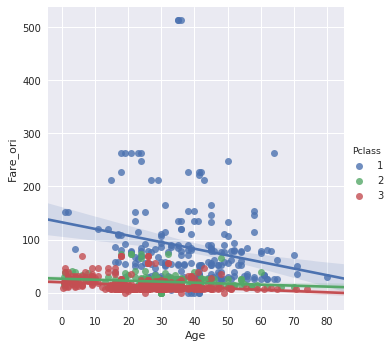

In [335]:
# Look into relationship between Age and Fare
sns.lmplot(x='Age', y='Fare_ori', hue='Pclass', data=df_fare[:892])

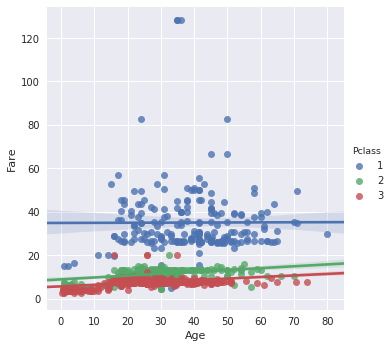

In [337]:
sns.lmplot(x='Age', y='Fare', hue='Pclass', data=df_tmp)

In [253]:
data_rd3 = df_fare.copy()

In [254]:
data_rd3.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Master,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,occurance,Fare_ori
0,22.0,S,7.25000,0,1,3,0,1,0.0,Mr,0,0,1,0,0,0,5.0,21171.0,1,7.2500
1,38.0,C,35.64165,0,2,1,1,1,1.0,Mrs,0,0,0,1,0,0,0.0,17599.0,2,71.2833
2,26.0,S,7.92500,0,3,3,1,0,1.0,Miss,0,1,0,0,0,0,2.0,3101282.0,1,7.9250
3,35.0,S,26.55000,0,4,1,1,1,1.0,Mrs,0,0,0,1,0,0,0.0,113803.0,2,53.1000
4,35.0,S,8.05000,0,5,3,0,0,0.0,Mr,0,0,1,0,0,0,0.0,373450.0,1,8.0500


Look into the relationship between Embarked and Fare given Pclass

In [255]:
fare_em = pd.concat([data_rd3['Embarked'], data_rd3['Fare'], data_rd3['Pclass']], axis=1, keys=['Embarked', 'Fare', 'Pclass'])

In [256]:
pc_unqiue = np.sort(fare_em.Pclass.unique())

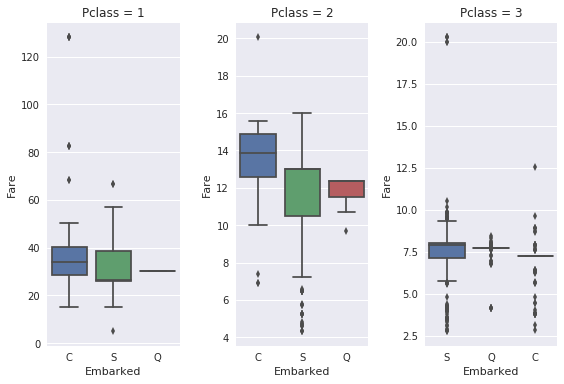

In [257]:
fig, ax = plt.subplots(1,3)
study_cont = 'Fare'
for i in range(len(pc_unqiue)):
    fare_em_tmp = fare_em[fare_em['Pclass']==pc_unqiue[i]]
    sns.boxplot(x=fare_em_tmp['Embarked'], y=fare_em_tmp[study_cont], ax=ax[i])
    ax[i].set_title('Pclass = {}'.format(pc_unqiue[i]))
plt.tight_layout()

Even after controlling Pclass and Embarked, there are still outliers in several of the fare distribution. This indicates that there are still uncontrolled factors influencing the fare. Let's look into the outliers to see if more processing needs to be performed on fare.

From the above outlier analysis, it is hard to see any obvious complication that triggers the abonormal prices. We will keep the values as it is for now. It is also hard to see any obvious influence of embarked location of the fare. We will therefore drop the Embarked feature.

In [258]:
# Perform one hot encodeing for embarked
one_hot_embarked = pd.get_dummies(data_rd3['Embarked'], prefix='Embarked')
data_rd3 = data_rd3.join(one_hot_embarked)
data_rd3.drop('Embarked', axis=1, inplace=True)

In [259]:
data_rd4 = data_rd3.copy()
# data_rd4.drop('ticket_num2', axis=1, inplace=True)
# data_rd4.drop('Fare', axis=1, inplace=True)
# data_rd4.drop('SibSp', axis=1, inplace=True)
# data_rd4.drop('Parch', axis=1, inplace=True)
# data_rd4.drop('occurance', axis=1, inplace=True)

In [260]:
one_hot_Pclass = pd.get_dummies(data_rd4['Pclass'], prefix='Pclass')
data_rd4 = data_rd4.join(one_hot_Pclass)
data_rd4.drop('Pclass', axis=1, inplace=True)

In [261]:
data_rd4.head()

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,title_name,Master,Miss,...,ticket_num1,ticket_num2,occurance,Fare_ori,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,7.25000,0,1,0,1,0.0,Mr,0,0,...,5.0,21171.0,1,7.2500,0,0,1,0,0,1
1,38.0,35.64165,0,2,1,1,1.0,Mrs,0,0,...,0.0,17599.0,2,71.2833,1,0,0,1,0,0
2,26.0,7.92500,0,3,1,0,1.0,Miss,0,1,...,2.0,3101282.0,1,7.9250,0,0,1,0,0,1
3,35.0,26.55000,0,4,1,1,1.0,Mrs,0,0,...,0.0,113803.0,2,53.1000,0,0,1,1,0,0
4,35.0,8.05000,0,5,0,0,0.0,Mr,0,0,...,0.0,373450.0,1,8.0500,0,0,1,0,0,1


In [262]:
data_rd4['Cabin'] = data['Cabin']
data_rd4.Cabin.fillna('U', inplace=True)
data_rd4['Cabin'] = data_rd4['Cabin'].astype(str).map(lambda c : c[0])
one_hot_cabin = pd.get_dummies(data_rd4['Cabin'], prefix='Cabine')
data_rd4 = data_rd4.join(one_hot_cabin)
data_rd4.drop('Cabin', axis=1, inplace=True)
data_rd4.drop('Fare_ori', axis=1, inplace=True)

In [263]:
data_rd4.head()

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,title_name,Master,Miss,...,Pclass_3,Cabine_A,Cabine_B,Cabine_C,Cabine_D,Cabine_E,Cabine_F,Cabine_G,Cabine_T,Cabine_U
0,22.0,7.25000,0,1,0,1,0.0,Mr,0,0,...,1,0,0,0,0,0,0,0,0,1
1,38.0,35.64165,0,2,1,1,1.0,Mrs,0,0,...,0,0,0,1,0,0,0,0,0,0
2,26.0,7.92500,0,3,1,0,1.0,Miss,0,1,...,1,0,0,0,0,0,0,0,0,1
3,35.0,26.55000,0,4,1,1,1.0,Mrs,0,0,...,0,0,0,1,0,0,0,0,0,0
4,35.0,8.05000,0,5,0,0,0.0,Mr,0,0,...,1,0,0,0,0,0,0,0,0,1


Next, we need to make every effort we have to fill the nan values in Age. Name title could serve as an important information.

In [288]:
data_rd5 = data_rd4.copy()

In [289]:
data_rd5.drop('title_name', axis=1, inplace=True)
data_rd5.drop('ticket_num1', axis=1, inplace=True)
data_rd5.drop('ticket_num2', axis=1, inplace=True)
data_rd5['group_size'] = data_rd5['Parch'] + data_rd5['SibSp'] + 1
data_rd5['Singleton'] = data_rd5['group_size'].map(lambda x: 1 if x == 1 else 0)
data_rd5['SmallFamily'] = data_rd5['group_size'].map(lambda x: 1 if 1 < x <5 else 0)
data_rd5['LargeFamily'] = data_rd5['group_size'].map(lambda x: 1 if x > 4 else 0)
data_rd5['Young'] = data_rd5['Age'].map(lambda x: 1 if x <15 else 0)
data_rd5['Old'] = data_rd5['Age'].map(lambda x: 1 if x > 45 else 0)

In [290]:
from sklearn.model_selection import train_test_split

train_data = data_rd5[data_rd5['PassengerId']<892]
# X_train, X_vali,y_train,y_vali = train_test_split(train_data, train_data['Survived'], test_size=0.1, random_state=23, stratify=train_data['Survived'])

In [291]:
X_train = train_data
y_train = train_data['Survived']
print(sorted(Counter(y_train).items()))

[(0.0, 549), (1.0, 342)]


In [292]:
# X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
# train_data1 = pd.DataFrame(X_resampled.astype(int), columns=data_rd5.columns)
# print(sorted(Counter(y_resampled).items()))
train_data1 = X_train
train_target1 = y_train

In [293]:
train_data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 35 columns):
Age            891 non-null float64
Fare           891 non-null float64
Parch          891 non-null int64
PassengerId    891 non-null int64
Sex            891 non-null int64
SibSp          891 non-null int64
Survived       891 non-null float64
Master         891 non-null uint8
Miss           891 non-null uint8
Mr             891 non-null uint8
Mrs            891 non-null uint8
Officer        891 non-null uint8
Royalty        891 non-null uint8
occurance      891 non-null int64
Embarked_C     891 non-null uint8
Embarked_Q     891 non-null uint8
Embarked_S     891 non-null uint8
Pclass_1       891 non-null uint8
Pclass_2       891 non-null uint8
Pclass_3       891 non-null uint8
Cabine_A       891 non-null uint8
Cabine_B       891 non-null uint8
Cabine_C       891 non-null uint8
Cabine_D       891 non-null uint8
Cabine_E       891 non-null uint8
Cabine_F       891 non-null uint8
Cabin

In [294]:
train_keep = train_data1.copy()
train_data1.drop('PassengerId', axis=1, inplace=True)
train_target1 = train_data1['Survived']
train_data1.drop('Survived', axis=1, inplace=True)
# train_data1.drop('Fare', axis=1, inplace=True)

In [327]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
clf = RandomForestClassifier(n_estimators=50)
clf = clf.fit(train_data1, train_target1)
clf_predict = clf.predict(train_data1)
accuracy_score(clf_predict, train_target1)

0.9854096520763187

From the preliminary results with can see that even letting XGBboost to fill in nan by itself. The training error is still high. We therefore needs to perform error analysis.

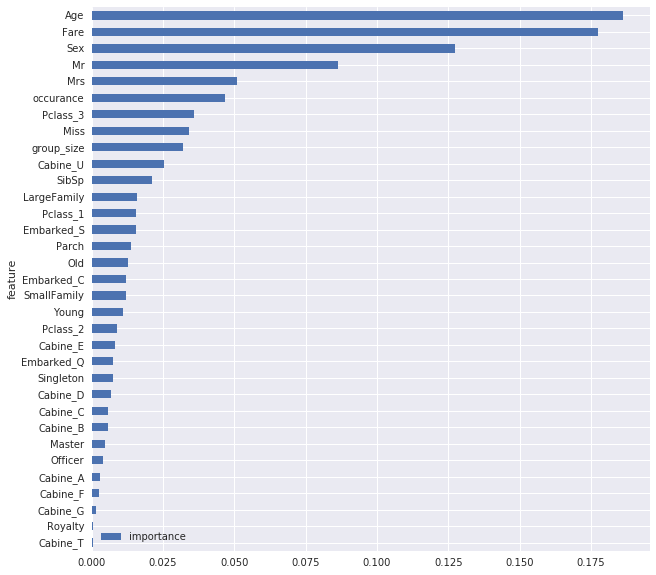

In [328]:
features = pd.DataFrame()
features['feature'] = train_data1.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(10, 10))

In [329]:
select_model = SelectFromModel(clf, prefit=True)
train_reduced = select_model.transform(train_data1)
train_reduced.shape

(891, 9)

In [330]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

run_gs = True

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [80, 50],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(train_target1, n_folds=10)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation)

    grid_search.fit(train_reduced, train_target1)
    rf_model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
else: 
    parameters = {'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 20, 'max_features': 'sqrt', 'max_depth': 6}
    
    rf_model = RandomForestClassifier(**parameters)
    rf_model.fit(train_reduced, train_target1)

Best score: 0.8395061728395061
Best parameters: {'n_estimators': 50, 'bootstrap': True, 'max_features': 'auto', 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3}


In [148]:
test_data = data_rd5[data_rd5['PassengerId']>891]
test_data.drop('Survived', axis=1, inplace=True)
test_data.drop('PassengerId', axis=1, inplace=True)
# test_data.drop('Fare', axis=1, inplace=True)
test_reduced = select_model.transform(test_data)
rf_test_predict = rf_model.predict(test_reduced ).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = rf_test_predict
df_output[['PassengerId','Survived']].to_csv('output.csv',index=False)
# list(rf_test_predict)

In [298]:
from sklearn.linear_model import LogisticRegressionCV

cross_validation = StratifiedKFold(train_target1, n_folds=10)
lr_clf = LogisticRegressionCV(scoring='accuracy', cv=cross_validation)
lr_clf.fit(train_reduced, train_target1)

LogisticRegressionCV(Cs=10, class_weight=None,
           cv=sklearn.cross_validation.StratifiedKFold(labels=[ 0.  1. ...,  1.  0.], n_folds=10, shuffle=False, random_state=None),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='accuracy',
           solver='lbfgs', tol=0.0001, verbose=0)

In [299]:
lr_clf.scores_

{1.0: array([[ 0.63333333,  0.64444444,  0.71111111,  0.78888889,  0.8       ,
          0.81111111,  0.81111111,  0.81111111,  0.81111111,  0.81111111],
        [ 0.62222222,  0.62222222,  0.7       ,  0.81111111,  0.81111111,
          0.82222222,  0.82222222,  0.82222222,  0.82222222,  0.82222222],
        [ 0.70786517,  0.71910112,  0.70786517,  0.7752809 ,  0.76404494,
          0.7752809 ,  0.7752809 ,  0.7752809 ,  0.7752809 ,  0.7752809 ],
        [ 0.71910112,  0.74157303,  0.7752809 ,  0.86516854,  0.86516854,
          0.86516854,  0.86516854,  0.86516854,  0.86516854,  0.86516854],
        [ 0.6741573 ,  0.68539326,  0.76404494,  0.83146067,  0.82022472,
          0.82022472,  0.82022472,  0.82022472,  0.82022472,  0.82022472],
        [ 0.62921348,  0.65168539,  0.76404494,  0.7752809 ,  0.79775281,
          0.79775281,  0.79775281,  0.79775281,  0.79775281,  0.79775281],
        [ 0.6741573 ,  0.69662921,  0.7752809 ,  0.78651685,  0.79775281,
          0.82022472,  0.82

In [300]:
lr_pred_train = lr_clf.predict(train_reduced)
accuracy_score(lr_pred_train, train_target1)

0.8125701459034792

In [776]:
test_data = data_rd5[data_rd5['PassengerId']>891]
test_data.drop('Survived', axis=1, inplace=True)
test_data.drop('PassengerId', axis=1, inplace=True)
# test_data.drop('Fare', axis=1, inplace=True)
test_reduced = select_model.transform(test_data)
rf_test_predict = lr_clf.predict(test_reduced)
df_output = pd.DataFrame()
aux = pd.read_csv('test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = rf_test_predict
df_output[['PassengerId','Survived']].to_csv('output.csv',index=False)

cv_score:0.8126337556701978
XGB classifier training accuracy:0.8832772166105499


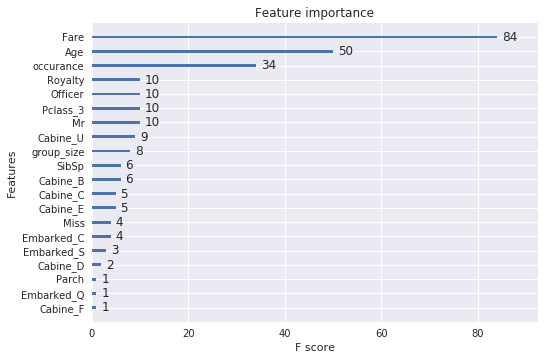

In [326]:
from sklearn import cross_validation

XGB_clf = XGBClassifier(n_estimators=10, max_depth=6)
cv_score = cross_validation.cross_val_score(XGB_clf, train_data1, train_target1, cv=5, scoring='accuracy')
print('cv_score:{}'.format(np.mean(cv_score)))

XGB_clf.fit(train_data1, train_target1)
XGB_predict2 = XGB_clf.predict(train_data1)
print('XGB classifier training accuracy:{}'.format(accuracy_score(XGB_predict2, train_target1)))

plot_importance(XGB_clf)
plt.show()

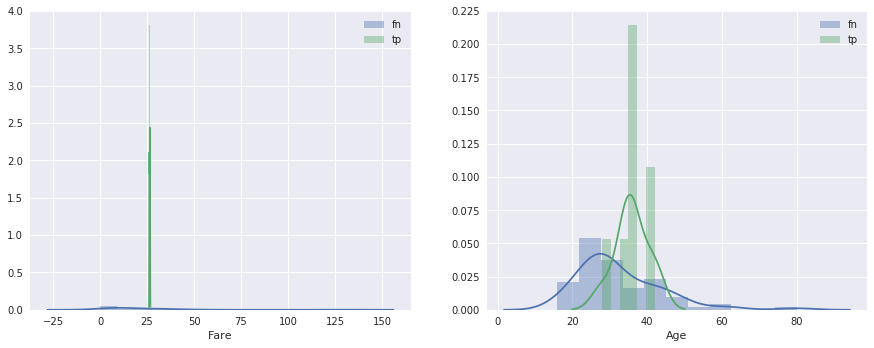

In [161]:
# Compare the false negative and true positive
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
sns.distplot(fn.loc[(fn['Mr']==1),'Fare'], label='fn',ax=ax[0])
sns.distplot(tp.loc[(tp['Mr']==1),'Fare'], label='tp',ax=ax[0])
sns.distplot(fn.loc[(fn['Mr']==1),'Age'], label='fn',ax=ax[1])
sns.distplot(tp.loc[(tp['Mr']==1),'Age'], label='tp',ax=ax[1])
ax[0].legend()
ax[1].legend()

From the above error analysis we can see that majority of the false negative comes from title = Mr with Pclass>1 and Fare_div < 25. We could do two things:
1. Create more training cases for this category
2. Engineer features to deal with the difference

In [1719]:
train_data = data_rd5[data_rd5['PassengerId']<892]
X_train, X_vali,y_train,y_vali = train_test_split(train_data, train_data['Survived'], test_size=0.1, random_state=23, stratify=train_data['Survived'])

In [1605]:
train_data.describe()

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,Mrs,Fare_div,occurance,Fare,Age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.381594,446.000000,2.308642,0.352413,0.523008,0.383838,0.044893,0.204265,0.580247,0.140292,14.656063,2.098765,32.204208,29.133749
std,0.806057,257.353842,0.836071,0.477990,1.102743,0.486592,0.207186,0.403390,0.493796,0.347485,13.698940,1.795534,49.693429,13.380245
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.420000
25%,0.000000,223.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.550000,1.000000,7.910400,22.000000
50%,0.000000,446.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.050000,1.000000,14.454200,28.250000
75%,0.000000,668.500000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,13.861450,2.500000,31.000000,35.500000
max,6.000000,891.000000,3.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,128.082300,11.000000,512.329200,80.000000


In [1606]:
print(sorted(Counter(y_train).items()))

[(0.0, 494), (1.0, 307)]


In [1629]:
train_data_boost = train_data[(train_data['Fare_div']<8)&(train_data['Pclass']>1)]

In [1630]:
train_data2 = train_data.append(train_data_boost)

In [1631]:
train_data2.describe()

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,Mrs,Fare_div,occurance,Fare,Age
count,1278.000000,1278.000000,1278.000000,1278.000000,1278.00000,1278.000000,1278.000000,1278.00000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000
mean,0.422535,446.209703,2.502347,0.342723,0.58529,0.352895,0.055556,0.21205,0.586072,0.125196,12.272050,2.172144,26.825677,27.746354
std,0.867869,259.507750,0.767127,0.474806,1.24337,0.478058,0.229151,0.40892,0.492729,0.331070,12.025868,1.958082,42.887435,13.148543
min,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.420000
25%,0.000000,217.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,7.225000,1.000000,7.796850,21.000000
50%,0.000000,443.500000,3.000000,0.000000,0.00000,0.000000,0.000000,0.00000,1.000000,0.000000,7.854200,1.000000,13.000000,28.250000
75%,1.000000,671.750000,3.000000,1.000000,1.00000,1.000000,0.000000,0.00000,1.000000,0.000000,11.000000,3.000000,27.720800,33.000000
max,6.000000,891.000000,3.000000,1.000000,8.00000,1.000000,1.000000,1.00000,1.000000,1.000000,128.082300,11.000000,512.329200,80.000000


In [1632]:
train_keep = train_data2.copy()
vali_keep = X_vali.copy()
vali_data2 = X_vali.copy()
train_data2.drop('PassengerId', axis=1, inplace=True)
vali_data2.drop('PassengerId', axis=1, inplace=True)
train_target2 = train_data2['Survived']
vali_target2 = vali_data2['Survived']
train_data2.drop('Survived', axis=1, inplace=True)
# train_data1.drop('SibSp', axis=1, inplace=True)
# train_data1.drop('Parch', axis=1, inplace=True)
train_data2.drop('Fare', axis=1, inplace=True)
# train_data1.drop('occurance', axis=1, inplace=True)
vali_data2.drop('Survived', axis=1, inplace=True)
# vali_data1.drop('SibSp', axis=1, inplace=True)
# vali_data1.drop('Parch', axis=1, inplace=True)
vali_data2.drop('Fare', axis=1, inplace=True)
# vali_data1.drop('occurance', axis=1, inplace=True)

cv_score:0.908498106927596
XGB classifier training accuracy:0.9827856025039123


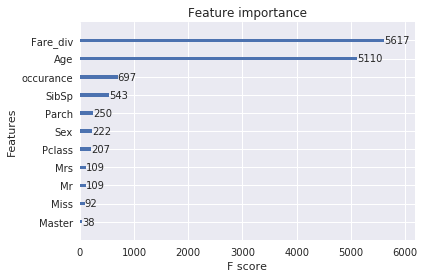

In [1633]:
XGB_clf = XGBClassifier(n_estimators=300, max_depth=60, min_child_weight=1)
cv_score = cross_validation.cross_val_score(XGB_clf, train_data2, train_target2, cv=5, scoring='accuracy')
print('cv_score:{}'.format(np.mean(cv_score)))

XGB_clf.fit(train_data2, train_target2)
XGB_predict2 = XGB_clf.predict(train_data2)
print('XGB classifier training accuracy:{}'.format(accuracy_score(XGB_predict2, train_target2)))

plot_importance(XGB_clf)
plt.show()

In [1634]:
pred_data2 = pd.Series(XGB_predict2, index=train_data2.index, name='Pred')
train_data2 = train_data2.join(pred_data2, how='outer')
train_data2 = train_data2.join(train_target2, how='outer')

In [1635]:
# Identify the mistakenly identified
fn = train_data2[train_data2['Pred'] - train_data2['Survived'] < 0]
tp = train_data2[(train_data2['Pred'] == 1.0)&(train_data2['Survived']==1.0)]
# Identify the mistakenly identified
fp = train_data2[train_data2['Pred'] - train_data2['Survived'] > 0]
tn = train_data2[(train_data2['Pred'] == 0.0)&(train_data2['Survived']==0.0)]

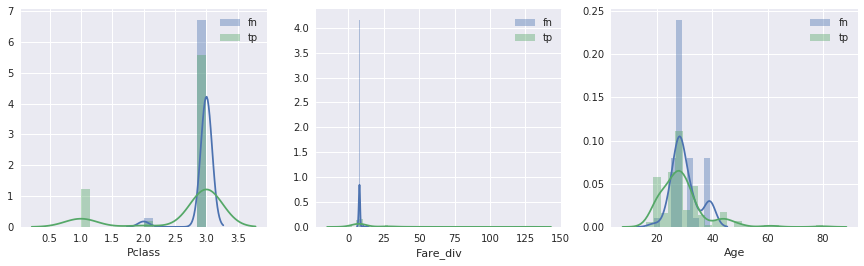

In [1636]:
# Compare the false negative and true positive
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
sns.distplot(fn.loc[(fn['Mr']==1),'Pclass'], label='fn', ax=ax[0])
sns.distplot(tp.loc[(tp['Mr']==1),'Pclass'], label='tp', ax=ax[0])
sns.distplot(fn.loc[(fn['Mr']==1),'Fare_div'], label='fn',ax=ax[1])
sns.distplot(tp.loc[(tp['Mr']==1),'Fare_div'], label='tp',ax=ax[1])
sns.distplot(fn.loc[(fn['Mr']==1),'Age'], label='fn',ax=ax[2])
sns.distplot(tp.loc[(tp['Mr']==1),'Age'], label='tp',ax=ax[2])
ax[0].legend()
ax[1].legend()
ax[2].legend()

From the above result, adding more samples of the training interest will create bias overfitting. We will try engineer feature for target training data.

In [1644]:
test_data = data_rd5[data_rd5['PassengerId']>891]
test_data.drop('Survived', axis=1, inplace=True)
test_data.drop('PassengerId', axis=1, inplace=True)
#test_data.drop('SibSp', axis=1, inplace=True)
#test_data.drop('Parch', axis=1, inplace=True)
test_data.drop('Fare', axis=1, inplace=True)
rf_test_predict = XGB_clf.predict(test_data)
# list(rf_test_predict)

In [1731]:
train_data = data_rd5[data_rd5['PassengerId']<892]
train_data.loc[(train_data['Mr']==1)&(train_data['Fare']<15)&(train_data['Fare']<1)]

,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Master,Miss,Mr,Mrs,Fare_div,occurance,Fare,Age
179,0,180,3,0,0,0.0,0,0,1,0,0.0,1.0,0.0,36.00
263,0,264,1,0,0,0.0,0,0,1,0,0.0,1.0,0.0,40.00
271,0,272,3,0,0,1.0,0,0,1,0,0.0,1.0,0.0,25.00
277,0,278,2,0,0,0.0,0,0,1,0,0.0,3.0,0.0,28.25
302,0,303,3,0,0,0.0,0,0,1,0,0.0,1.0,0.0,19.00
413,0,414,2,0,0,0.0,0,0,1,0,0.0,3.0,0.0,28.25
466,0,467,2,0,0,0.0,0,0,1,0,0.0,3.0,0.0,28.25
481,0,482,2,0,0,0.0,0,0,1,0,0.0,1.0,0.0,28.25
597,0,598,3,0,0,0.0,0,0,1,0,0.0,1.0,0.0,49.00
633,0,634,1,0,0,0.0,0,0,1,0,0.0,1.0,0.0,28.25


In [1726]:
train_data.loc[(train_data['Mr']==1)&(train_data['Fare']<15), 'Fare']

179     0.0000
263     0.0000
271     0.0000
277     0.0000
302     0.0000
378    12.0375
413     0.0000
466     0.0000
481     0.0000
597     0.0000
633     0.0000
674     0.0000
732     0.0000
806     0.0000
815     0.0000
Name: Fare, dtype: float64

In [1724]:
train_data.loc[(train_data['Mr']==1)&(train_data['Fare']<15), 'Fare'] = train_data.loc[(train_data['Mr']==1)&(train_data['Fare']<15), 'Fare'] * 3
X_train, X_vali,y_train,y_vali = train_test_split(train_data, train_data['Survived'], test_size=0.1, random_state=23, stratify=train_data['Survived'])

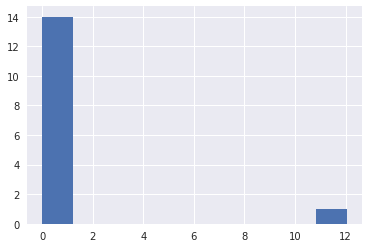

In [1725]:
train_data.loc[(train_data['Mr']==1)&(train_data['Fare']<15), 'Fare'].hist()

In [1713]:
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
train_data1 = pd.DataFrame(X_resampled.astype(int)+1, columns=data_rd5.columns)
vali_data1 = pd.DataFrame(X_vali, columns=data_rd5.columns)
print(sorted(Counter(y_resampled).items()))
# train_data1 = X_train
# vali_data1 = X_vali

[(0.0, 494), (1.0, 494)]


In [1714]:
train_keep = train_data1.copy()
vali_keep = vali_data1.copy()
train_data1.drop('PassengerId', axis=1, inplace=True)
vali_data1.drop('PassengerId', axis=1, inplace=True)
train_target1 = train_data1['Survived']
vali_target1 = vali_data1['Survived']
train_data1.drop('Survived', axis=1, inplace=True)
# train_data1.drop('SibSp', axis=1, inplace=True)
# train_data1.drop('Parch', axis=1, inplace=True)
train_data1.drop('Fare', axis=1, inplace=True)
# train_data1.drop('occurance', axis=1, inplace=True)
vali_data1.drop('Survived', axis=1, inplace=True)
# vali_data1.drop('SibSp', axis=1, inplace=True)
# vali_data1.drop('Parch', axis=1, inplace=True)
vali_data1.drop('Fare', axis=1, inplace=True)
# vali_data1.drop('occurance', axis=1, inplace=True)

cv_score:0.842238713667285
XGB classifier training accuracy:0.9453441295546559


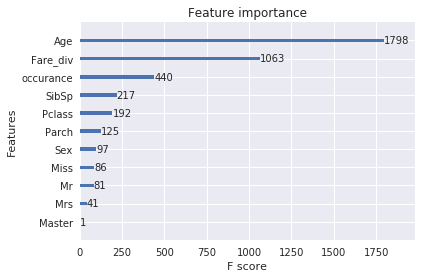

In [1715]:
XGB_clf = XGBClassifier(n_estimators=80, max_depth=20, min_child_weight=1)
cv_score = cross_validation.cross_val_score(XGB_clf, train_data1, train_target1, cv=5, scoring='accuracy')
print('cv_score:{}'.format(np.mean(cv_score)))

XGB_clf.fit(train_data1, train_target1)
XGB_predict1 = XGB_clf.predict(train_data1)
print('XGB classifier training accuracy:{}'.format(accuracy_score(XGB_predict1, train_target1)))

plot_importance(XGB_clf)
plt.show()

In [1640]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(train_data1, train_target1)

lr_predict = lr_clf.predict(train_data1)
print('Logistic regression classifier training accuracy:{}'.format(accuracy_score(lr_predict, train_target1)))

lr_predict = lr_clf.predict(vali_data1)
print('Logistic regression classifier validation accuracy:{}'.format(accuracy_score(lr_predict, vali_target1)))

Logistic regression classifier training accuracy:1.0


ValueError: X has 11 features per sample; expecting 13

In [ ]:
# Split into train and validation set
#train_data1_part1 = data_rd1[(data_rd1['PassengerId']<892)&(data_rd1['Age']<15)].sample(frac=0.5, random_state=1).reset_index(drop=True)   # Shuffle the data
#train_data1_part2 = data_rd1[(data_rd1['PassengerId']<892)&(data_rd1['Age']>15)].sample(frac=1, random_state=1).reset_index(drop=True)   # Shuffle the data
#train_data1 = pd.concat([train_data1_part1, train_data1_part2])
from sklearn.model_selection import train_test_split

train_data = data_rd1[data_rd1['PassengerId']<892]
train_data = train_data.dropna(axis=0, how='any')
X_train, X_vali,y_train,y_vali = train_test_split(train_data, train_data['Survived'], test_size=0.1, random_state=23, stratify=train_data['Survived'])

In [ ]:
print(sorted(Counter(y_train).items()))

In [ ]:
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
train_data1 = pd.DataFrame(X_resampled, columns=data_rd1.columns)
vali_data1 = pd.DataFrame(X_vali, columns=data_rd1.columns)
print(sorted(Counter(y_resampled).items()))
# train_data1 = X_train
# vali_data1 = X_vali

In [ ]:
train_data1.drop('PassengerId', axis=1, inplace=True)
vali_data1.drop('PassengerId', axis=1, inplace=True)
train_target1 = train_data1['Survived']
vali_target1 = vali_data1['Survived']
train_data1.drop('Survived', axis=1, inplace=True)
vali_data1.drop('Survived', axis=1, inplace=True)

In [ ]:
XGB_clf = XGBClassifier()
XGB_clf.fit(train_data1, train_target1)

plot_importance(XGB_clf)
plt.show()

XGB_predict = XGB_clf.predict(train_data1)
print('XGB classifier training accuracy:{}'.format(accuracy_score(XGB_predict, train_target1)))

XGB_predict = XGB_clf.predict(vali_data1)
print('XGB classifier validation accuracy:{}'.format(accuracy_score(XGB_predict, vali_target1)))

In [ ]:
test_data.info()

In [ ]:
test_data = data_rd1[data_rd1['PassengerId']>891]
test_data.drop('Survived', axis=1, inplace=True)
test_data.drop('PassengerId', axis=1, inplace=True)
xgb_test_predict = XGB_clf.predict(test_data)
list(xgb_test_predict)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(train_data1, train_target1)

rf_predict = rf_clf.predict(train_data1)
print('RF classifier training accuracy:{}'.format(accuracy_score(rf_predict, train_target1)))

rf_predict = rf_clf.predict(vali_data1)
print('RF classifier validation accuracy:{}'.format(accuracy_score(rf_predict, vali_target1)))

In [ ]:
rf_test_predict = rf_clf.predict(test_data)
list(rf_test_predict)

In [ ]:
def modelfit(alg, dtrain, targets, performCV=True, printFeatureImportance=True, cv_folds=10):
    
    #Fit the algorithm on the data
    alg.fit(dtrain, targets)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain, targets, cv=cv_folds, scoring='accuracy')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(targets.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(targets, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        plot_importance(XGB_clf)
        plt.show()

In [ ]:
param_test1 = {
 'n_estimators':range(85,95,1),
 'max_depth':range(6,8,1),
 'min_child_weight':range(2,4,1)
}

estimator1 = XGBClassifier( learning_rate =0.1, n_estimators=90, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator1, param_grid = param_test1, scoring='f1',n_jobs=-1,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
vali_data1.info()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV

In [ ]:
# # Perform hyperparameter search for gradient boosting classifier
# gb_clf = GradientBoostingClassifier()
# param_grid=[{'learning_rate':[0.05, 0.1], 'n_estimators':[50, 100, 200], 'max_depth':[2,5,10], 'max_features' : [2,4,6,8]},]
# gb_clf = GradientBoostingClassifier()

# grid_search = GridSearchCV(gb_clf, param_grid, cv=5, scoring='accuracy')

# grid_search.fit(train_data1, train_target1)
# print(grid_search.best_params_, grid_search.best_score_)

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance

XGB_clf = XGBClassifier()
XGB_clf.fit(train_data1, train_target1)

plot_importance(XGB_clf)
plt.show()


XGB_predict = XGB_clf.predict(train_data1)
print('XGB classifier training accuracy:{}'.format(f1_score(XGB_predict, train_target1)))

### Perform hyperparameter search on XGB classifier 

In [ ]:
from sklearn import metrics
from sklearn import cross_validation

def modelfit(alg, dtrain, targets, performCV=True, printFeatureImportance=True, cv_folds=10):
    
    #Fit the algorithm on the data
    alg.fit(dtrain, targets)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain, targets, cv=cv_folds, scoring='accuracy')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(targets.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(targets, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        plot_importance(XGB_clf)
        plt.show()

In [ ]:
param_test1 = {
 'n_estimators':range(90,180,10),
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120, max_depth=3,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
 'n_estimators':range(165,175,1),
 'max_depth':range(8,10,1),
 #'min_child_weight':range(2,4,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=169, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120, max_depth=3,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=120,
 max_depth=3,
 min_child_weight=5,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train_data1, train_target1)

In [ ]:
param_test1 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=169, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
 'subsample':[i/100.0 for i in range(85,95,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=169, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=169, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {
 'reg_alpha':[1e-5, 5e-5, 1e-4,]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=169, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.75, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='f1',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=169,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.9,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=1e-5,
 seed=27)
modelfit(xgb2, train_data1, train_target1)

In [ ]:
# Analyze the mistake made by the model
from sklearn.metrics import confusion_matrix
xgb2.fit(train_data1, train_target1)
xgb_predict = xgb2.predict(train_data1)
confusion_matrix(train_target1, xgb_predict)

In [ ]:
xgb_predict_vali = xgb2.predict(vali_data1)
accuracy_score(vali_target1, xgb_predict_vali)
confusion_matrix(vali_target1, xgb_predict_vali)

In [ ]:
test_data = data_rd1[data_rd1['PassengerId']>892]
test_data.drop('Survived', axis=1, inplace=True)
test_data.drop('PassengerId', axis=1, inplace=True)
xgb_test_predict = xgb2.predict(test_data)
list(xgb_test_predict)

From the confusion matrix, we could see that more true false negative case were classfied (63). This might due to the imbalance of the training data size. 

In [ ]:
# Try using KNN to vote for the label
train_data1_reduced =  pd.concat([train_data1['Norm_fare'], train_data1['Age'], train_data1['Group_size'], train_data1['Sex'], train_data1['Pclass']], axis=1, keys=['Norm_fare', 'Age', 'Group_size', 'Sex', 'Pclass'])
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data1_scaled = scaler.fit_transform(train_data1_reduced)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
param_grid={'n_neighbors': np.arange(3,7,1),}
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=10, scoring='accuracy')

grid_search.fit(train_data1_scaled, train_target1)
print(grid_search.best_params_, grid_search.best_score_)

In [ ]:
from sklearn.neural_network import MLPClassifier

MLP_clf = MLPClassifier(solver='lbfgs', alpha=2e-4, hidden_layer_sizes=(7, 3), random_state=1)

MLP_clf.fit(train_data1_scaled, train_target1)

In [ ]:
train_predict=MLP_clf.predict(train_data1_scaled)

accuracy_score(train_predict, train_target1)

In [ ]:
# Perform cross validation on MLP

